In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#read in csv files. Only went back to 2000 for now but we can get more later if we want,
fuel_cons_2023 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2023%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2022 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2022%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2021 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2021%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2020 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2020%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2019 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2019%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2018 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2018%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2017 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2017%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2016 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2016%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2015 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2015%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2010_2014 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2010-2014%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252")
fuel_cons_2005_2009 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2005-2009%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252")
fuel_cons_2000_2004 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2000-2004%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252")


/var/folders/7c/glh90ckd7bdfn7cc0xbs4hgr0000gn/T/ipykernel_85392/2667824920.py:2: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  fuel_cons_2023 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2023%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
/var/folders/7c/glh90ckd7bdfn7cc0xbs4hgr0000gn/T/ipykernel_85392/2667824920.py:3: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  fuel_cons_2022 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2022%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
/var/folders/7c/glh90ckd7bdfn7cc0xbs4hgr0000gn/T/ipykernel_85392/2667824920.py:4: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  fuel_cons_2021 = pd.read_csv("https://www.nrc

In [4]:
#cleaning

#drop rows of entirely NaN, then cols of entirely Nan, then rows with some NaN
#there was ~50 rows at the bottom with text explaining the data, hence the need for the last drop
cleaner_fuel_cons_2023 = fuel_cons_2023.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2022 = fuel_cons_2022.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2021 = fuel_cons_2021.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2020 = fuel_cons_2020.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2019 = fuel_cons_2019.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2018 = fuel_cons_2018.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2017 = fuel_cons_2017.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2016 = fuel_cons_2016.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2015 = fuel_cons_2015.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2010_2014 = fuel_cons_2010_2014.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2005_2009 = fuel_cons_2005_2009.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2000_2004 = fuel_cons_2000_2004.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)

#renaming columns. Originally they were split between the first two rows, some got lost in the cleaning.
#useful to get rid of spaces and stuff anyways
col_names = ["model_year", "make", "model", "vehicle_class", "engine_size_L", "cylinders", "transmission", 
             "fuel_type", "city_fuel_cons", "hwy_fuel_cons", "comb_lpkm", "comb_mpg", "co2_emissions", 
             "co2_rating","smog_rating"]

cleaner_fuel_cons_2023.columns = col_names
cleaner_fuel_cons_2022.columns = col_names
cleaner_fuel_cons_2021.columns = col_names
cleaner_fuel_cons_2020.columns = col_names
cleaner_fuel_cons_2019.columns = col_names
cleaner_fuel_cons_2018.columns = col_names
cleaner_fuel_cons_2017.columns = col_names

#older data has less cols, 2016 missing smog rating, 2015 and older also missing co2 rating
cleaner_fuel_cons_2016.columns = col_names[:-1]

cleaner_fuel_cons_2015.columns = col_names[:-2]
cleaner_fuel_cons_2010_2014.columns = col_names[:-2]
cleaner_fuel_cons_2005_2009.columns = col_names[:-2]
cleaner_fuel_cons_2000_2004.columns = col_names[:-2]



In [5]:
#concat

full_dataset = pd.concat([cleaner_fuel_cons_2023, cleaner_fuel_cons_2022, cleaner_fuel_cons_2021
                            , cleaner_fuel_cons_2020, cleaner_fuel_cons_2019, cleaner_fuel_cons_2018
                            , cleaner_fuel_cons_2017, cleaner_fuel_cons_2016, cleaner_fuel_cons_2015
                            , cleaner_fuel_cons_2010_2014, cleaner_fuel_cons_2005_2009
                            , cleaner_fuel_cons_2000_2004], axis=0)
full_dataset

,model_year,make,model,vehicle_class,engine_size_L,cylinders,transmission,fuel_type,city_fuel_cons,hwy_fuel_cons,comb_lpkm,comb_mpg,co2_emissions,co2_rating,smog_rating
1,2023,Acura,Integra,Full-size,1.5,4.0,AV7,Z,7.9,6.3,7.2,39,167,6,7
2,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,AV7,Z,8.1,6.5,7.4,38,172,6,7
3,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,M6,Z,8.9,6.5,7.8,36,181,6,6
4,2023,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS10,Z,12.6,9.4,11.2,25,263,4,5
5,2023,Acura,MDX SH-AWD Type S,SUV: Standard,3.0,6.0,AS10,Z,13.8,11.2,12.4,23,291,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,2004,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,AS5,Z,14.4,10.2,12.5,23,288,NaN,NaN
3773,2004,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,M5,Z,13.4,9.8,11.8,24,271,NaN,NaN
3774,2004,VOLVO,XC70 AWD TURBO,SUV,2.5,5.0,AS5,Z,14.2,10.4,12.5,23,288,NaN,NaN
3775,2004,VOLVO,XC90 2.5T AWD TURBO,SUV,2.5,5.0,AS5,Z,14.9,10.7,13.0,22,299,NaN,NaN


In [6]:
# update the fuel types from letters to their actual meanings
full_dataset["fuel_type"].replace({"X": "Regular Gasoline",
                                     "Z": "Premium Gasoline",
                                     "D": "Diesel",
                                     "E": "Ethanol",
                                     "N": "Natural Gas"}, inplace = True)

# Different capitalizations and hyphens/colons were used in different years of vehicle_class. Update for consistency.
full_dataset["vehicle_class"].replace({"COMPACT": "Compact",
                                       "FULL-SIZE": "Full-size",
                                       "MID-SIZE": "Mid-size",
                                       "MINICOMPACT": "Minicompact",
                                       "MINIVAN": "Minivan",
                                       "TWO-SEATER": "Two-seater",
                                       "PICKUP TRUCK - SMALL": "Pickup truck: Small",
                                       "PICKUP TRUCK - STANDARD": "Pickup truck: Standard",
                                       "SPECIAL PURPOSE VEHICLE": "Special purpose vehicle",
                                       "VAN - PASSENGER": "Van: Passenger",
                                       "STATION WAGON - MID-SIZE": "Station wagon: Mid-size",
                                       "STATION WAGON - SMALL": "Station wagon: Small",
                                       "SUBCOMPACT": "Subcompact",
                                       "SUV - SMALL": "SUV: Small",
                                       "SUV - STANDARD": "SUV: Standard",
                                       "VAN - CARGO": "Van: Cargo"}, inplace = True)

# Different capitalizations of makes were used in different years. Update for consistency.
full_dataset["make"] = full_dataset["make"].str.lower()
full_dataset["make"] = full_dataset["make"].str.capitalize()

# verify changes
full_dataset.head()

,model_year,make,model,vehicle_class,engine_size_L,cylinders,transmission,fuel_type,city_fuel_cons,hwy_fuel_cons,comb_lpkm,comb_mpg,co2_emissions,co2_rating,smog_rating
1,2023,Acura,Integra,Full-size,1.5,4.0,AV7,Premium Gasoline,7.9,6.3,7.2,39,167,6,7
2,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,AV7,Premium Gasoline,8.1,6.5,7.4,38,172,6,7
3,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,M6,Premium Gasoline,8.9,6.5,7.8,36,181,6,6
4,2023,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS10,Premium Gasoline,12.6,9.4,11.2,25,263,4,5
5,2023,Acura,MDX SH-AWD Type S,SUV: Standard,3.0,6.0,AS10,Premium Gasoline,13.8,11.2,12.4,23,291,4,5


In [7]:
# view data types
print(full_dataset.dtypes)

# convert strings to numbers
full_dataset["model_year"] = full_dataset["model_year"].astype(int)
cols = ["engine_size_L", "city_fuel_cons", "hwy_fuel_cons", "comb_lpkm", "comb_mpg", "co2_emissions", "co2_rating", "smog_rating"]
full_dataset[cols] = full_dataset[cols].astype(float)

# checking new data types
print(full_dataset.dtypes)

model_year         object
make               object
model              object
vehicle_class      object
engine_size_L      object
cylinders         float64
transmission       object
fuel_type          object
city_fuel_cons     object
hwy_fuel_cons      object
comb_lpkm          object
comb_mpg           object
co2_emissions      object
co2_rating         object
smog_rating        object
dtype: object
model_year          int64
make               object
model              object
vehicle_class      object
engine_size_L     float64
cylinders         float64
transmission       object
fuel_type          object
city_fuel_cons    float64
hwy_fuel_cons     float64
comb_lpkm         float64
comb_mpg          float64
co2_emissions     float64
co2_rating        float64
smog_rating       float64
dtype: object


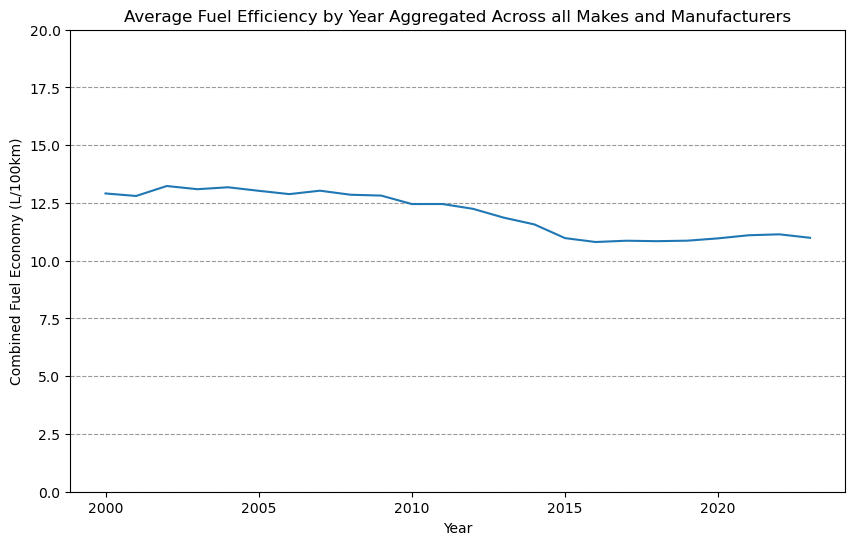

In [8]:
full_dataset_year_as_index = full_dataset.set_index("model_year")
years = full_dataset_year_as_index.groupby("model_year")

ax = years.mean()["comb_lpkm"].plot(figsize=(10, 6))
fig = ax.get_figure()
ax.set_ylim(0, 20)
ax.set_title("Average Fuel Efficiency by Year Aggregated Across all Makes and Manufacturers")
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.yaxis.grid(True, color="black", alpha = 0.4, linestyle='--')

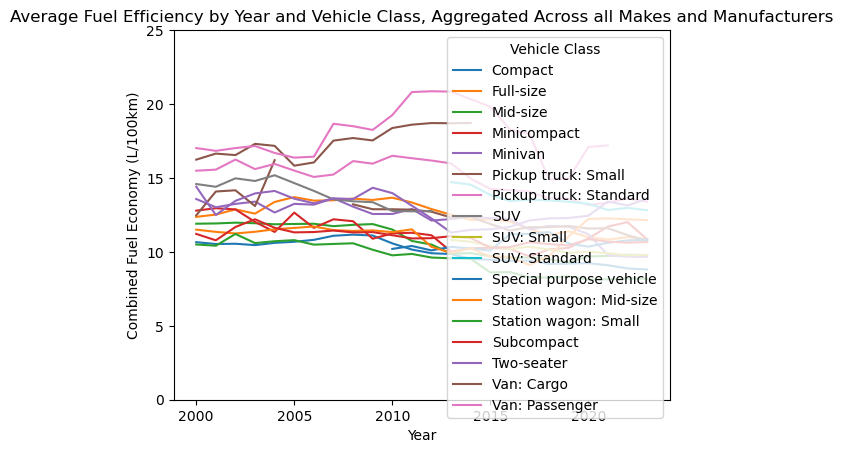

In [9]:
fuel_economy_by_year_and_vehicle_type = full_dataset.pivot_table(index="model_year", columns="vehicle_class", values="comb_lpkm", aggfunc="mean")
# drop the UL column, as it was only used in 2007
fuel_economy_by_year_and_vehicle_type.drop("UL", axis=1, inplace=True)

ax = fuel_economy_by_year_and_vehicle_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Average Fuel Efficiency by Year and Vehicle Class, Aggregated Across all Makes and Manufacturers")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='upper right')

Index(['Acura', 'Alfa romeo', 'Aston martin', 'Audi', 'Bentley', 'Bmw',
       'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo',
       'Dodge', 'Ferrari', 'Fiat', 'Ford', 'Genesis', 'Gmc', 'Honda', 'Hummer',
       'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Lamborghini',
       'Land rover', 'Lexus', 'Lincoln', 'Maserati', 'Mazda', 'Mercedes-benz',
       'Mini', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac',
       'Porsche', 'Ram', 'Rolls-royce', 'Saab', 'Saturn', 'Scion', 'Smart',
       'Srt', 'Subaru', 'Suzuki', 'Toyota', 'Volkswagen', 'Volvo'],
      dtype='object', name='make')


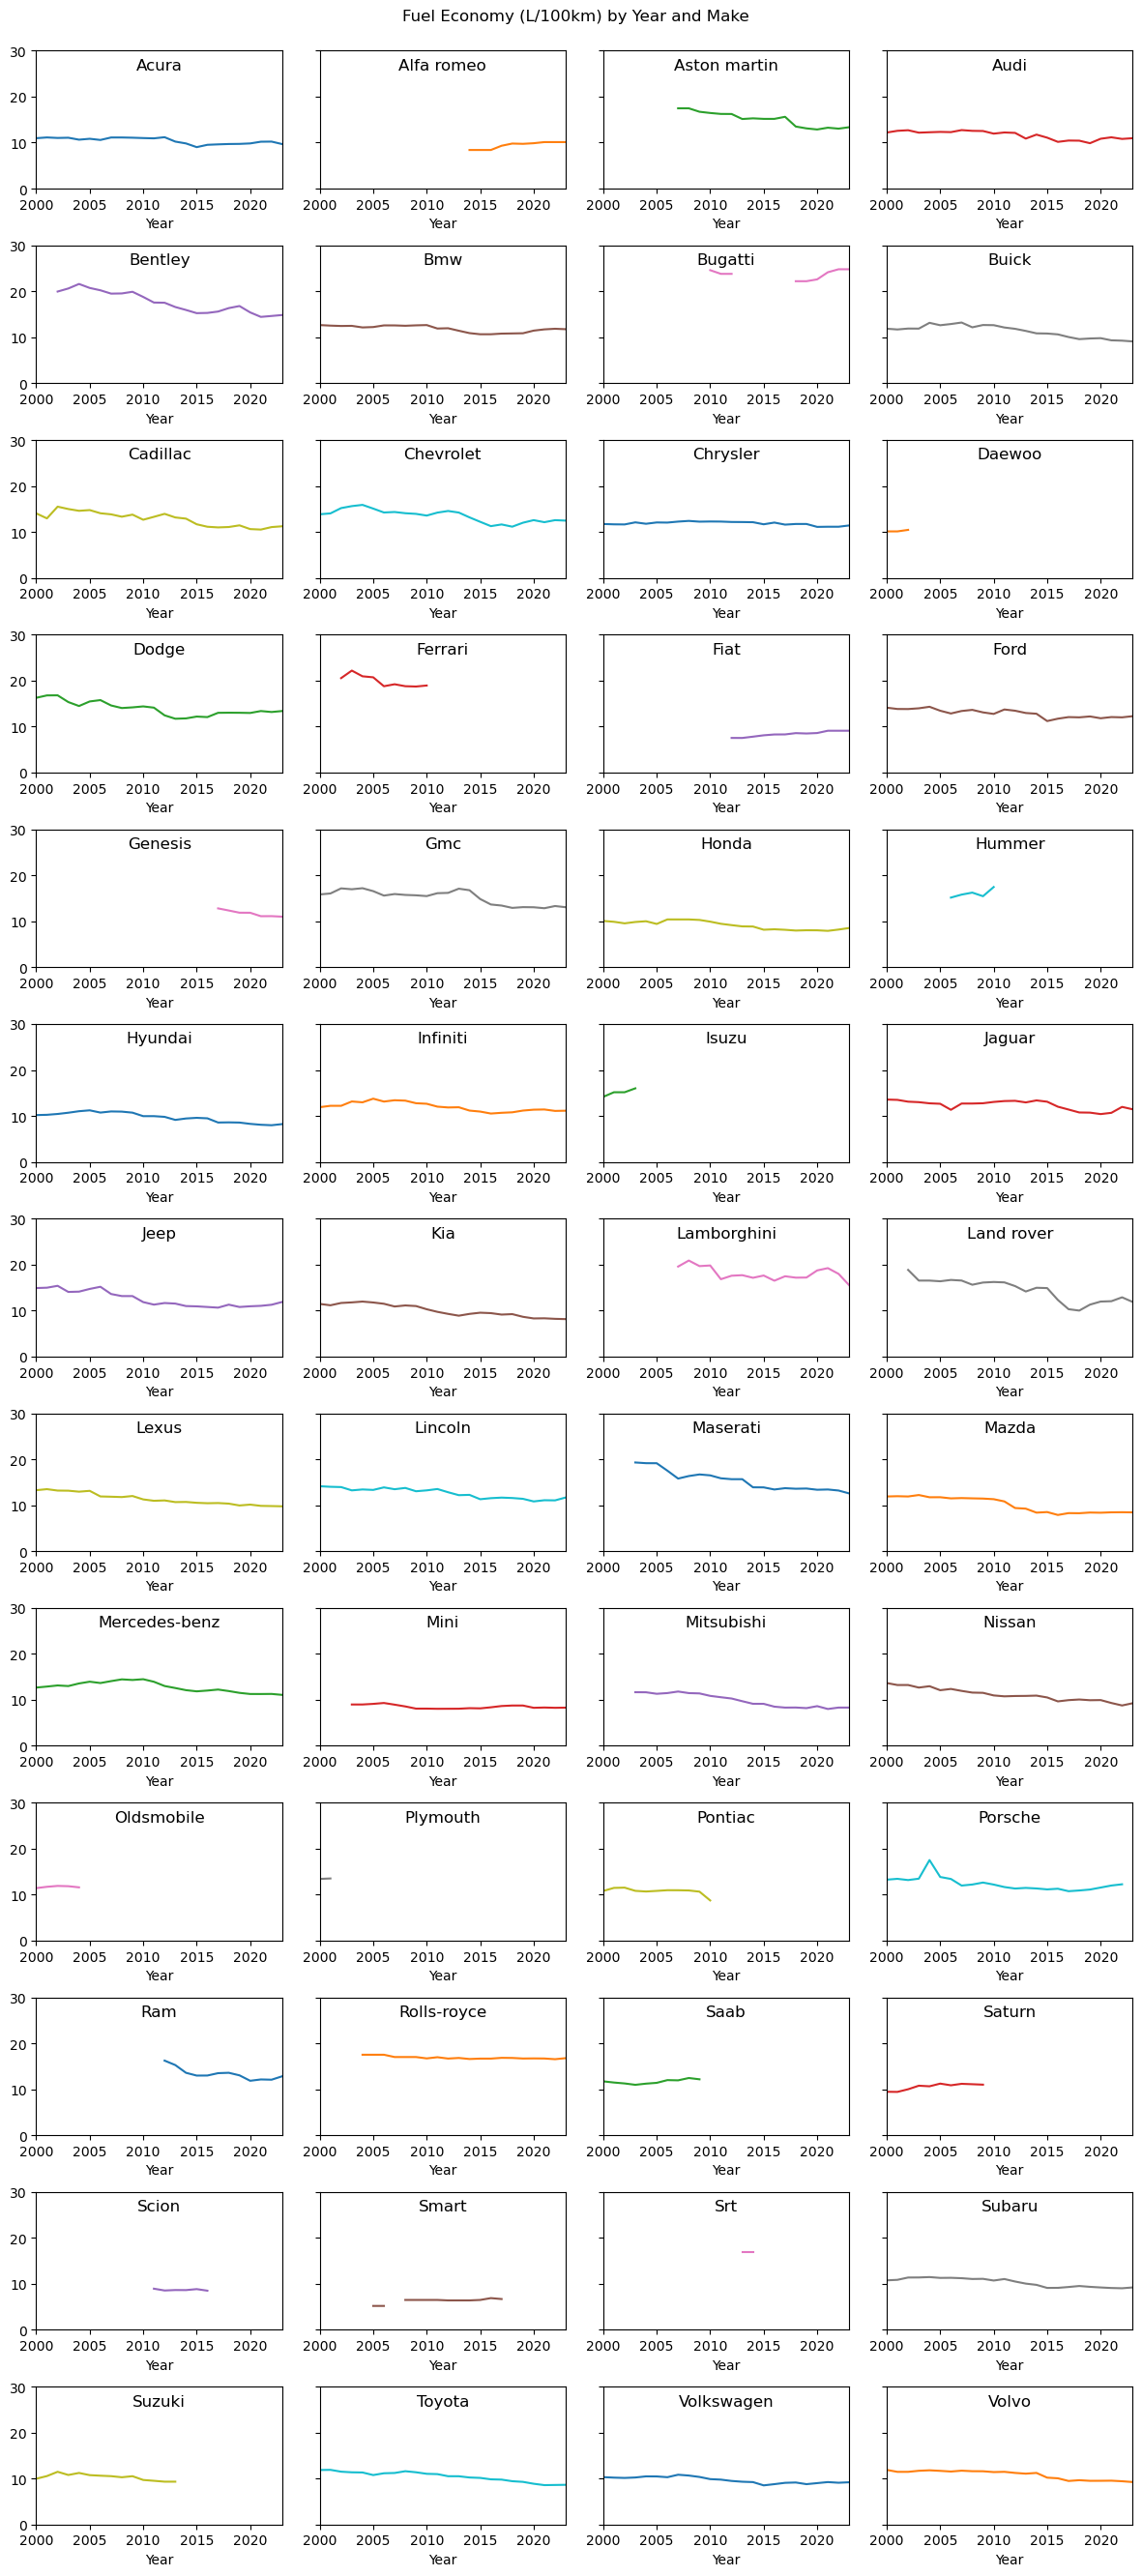

In [10]:
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", columns="make", values="comb_lpkm", aggfunc="mean")
print(fuel_economy_by_year_and_make.columns)

axs = fuel_economy_by_year_and_make.plot.line(
    figsize=(12, 28), subplots=True, legend=False, sharex=False,
    sharey=True, layout=(13, 4), grid=False, xlabel="Year"
)

axs[0,0].get_figure().tight_layout(rect=[0, 0.03, 1, 0.97])
axs[0,0].get_figure().suptitle('Fuel Economy (L/100km) by Year and Make')
axs = axs.flatten()
titles = fuel_economy_by_year_and_make.columns
i = 0
for ax in axs:
    title = titles[i]
    ax.set_title(title, y=1.0, pad=-14)
    ax.set_ylim(0, 30)
    ax.set_xlim(2000, 2023)
    i += 1

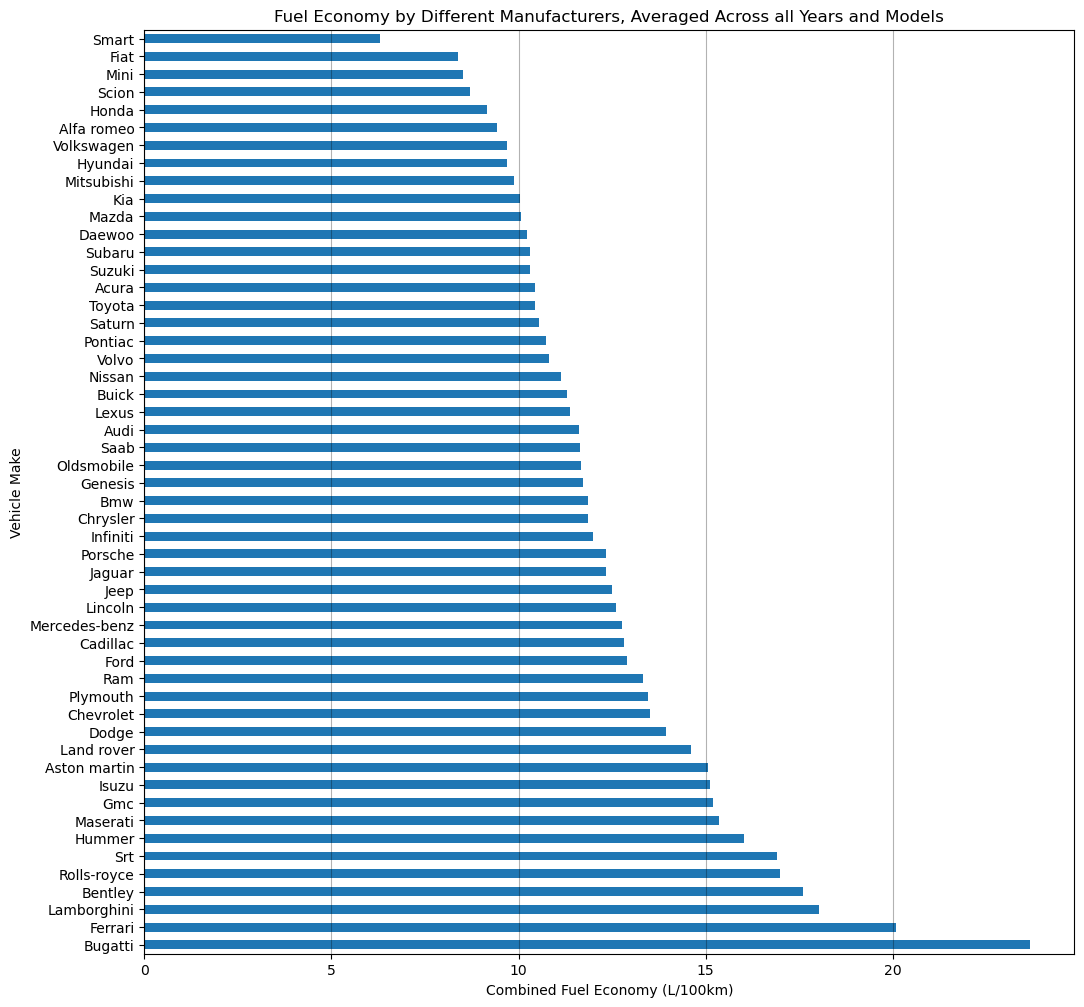

In [11]:
ax = fuel_economy_by_year_and_make.mean().sort_values(ascending=False).plot(kind="barh", figsize=(12, 12))
ax.set_ylabel("Vehicle Make")
ax.set_xlabel("Combined Fuel Economy (L/100km)")
ax.set_title("Fuel Economy by Different Manufacturers, Averaged Across all Years and Models")
plt.grid(c='black', alpha=0.3)
ax.yaxis.grid(False)

In [12]:
fuel_economy_by_year_make_and_vehicle_type = full_dataset.pivot_table(index=["model_year", "make"], columns="vehicle_class", values="comb_lpkm", aggfunc="mean")
# drop the UL column, as it was only used in 2007
fuel_economy_by_year_make_and_vehicle_type.drop("UL", axis=1, inplace=True)

fuel_economy_by_year_make_and_vehicle_type.reset_index(["model_year"], inplace=True)
fuel_economy_by_year_make_and_vehicle_type

by_year = fuel_economy_by_year_make_and_vehicle_type.groupby("model_year")
by_year.idxmin()

vehicle_class,Compact,Full-size,Mid-size,Minicompact,Minivan,Pickup truck: Small,Pickup truck: Standard,SUV,SUV: Small,SUV: Standard,Special purpose vehicle,Station wagon: Mid-size,Station wagon: Small,Subcompact,Two-seater,Van: Cargo,Van: Passenger
model_year,,,,,,,,,,,,,,,,,
2000,Saturn,Toyota,Honda,Audi,Chevrolet,Isuzu,Nissan,Subaru,NaN,NaN,NaN,Ford,Suzuki,Suzuki,Audi,Ford,Gmc
2001,Honda,Toyota,Honda,Audi,Chevrolet,Gmc,Toyota,Subaru,NaN,NaN,NaN,Ford,Suzuki,Suzuki,Honda,Chevrolet,Chevrolet
2002,Honda,Toyota,Toyota,Audi,Chevrolet,Chevrolet,Mazda,Subaru,NaN,NaN,NaN,Ford,Suzuki,Saturn,Honda,Gmc,Chevrolet
2003,Honda,Toyota,Honda,Mini,Chevrolet,Chevrolet,Toyota,Subaru,NaN,NaN,NaN,Ford,Pontiac,Volkswagen,Honda,Ford,Chevrolet
2004,Honda,Toyota,Toyota,Mini,Dodge,Chevrolet,Mazda,Saturn,NaN,NaN,NaN,Ford,Pontiac,Volkswagen,Honda,Ford,Chevrolet
2005,Honda,Chevrolet,Toyota,Mini,Honda,NaN,Mazda,Saturn,NaN,NaN,NaN,Volkswagen,Pontiac,Toyota,Smart,Ford,Chevrolet
2006,Honda,Hyundai,Toyota,Mini,Honda,NaN,Mazda,Saturn,NaN,NaN,NaN,Ford,Volkswagen,Volkswagen,Smart,Chevrolet,Chevrolet
2007,Honda,Toyota,Toyota,Mini,Toyota,NaN,Mazda,Subaru,NaN,NaN,NaN,Ford,Honda,Toyota,Mazda,Ford,Chevrolet
2008,Kia,Honda,Toyota,Mini,Mazda,Toyota,Honda,Subaru,NaN,NaN,NaN,Subaru,Honda,Toyota,Smart,Chevrolet,Chevrolet


## Grouping vehicle types

In [20]:
fuel_economy_by_year_and_vehicle_type = full_dataset.pivot_table(index="model_year", columns="vehicle_class", values="comb_lpkm", aggfunc="mean")
# drop the UL column, as it was only used in 2007
fuel_economy_by_year_and_vehicle_type.drop("UL", axis=1, inplace=True)
fuel_economy_by_year_and_vehicle_type

vehicle_class,Compact,Full-size,Mid-size,Minicompact,Minivan,Pickup truck: Small,Pickup truck: Standard,SUV,SUV: Small,SUV: Standard,Special purpose vehicle,Station wagon: Mid-size,Station wagon: Small,Subcompact,Two-seater,Van: Cargo,Van: Passenger
model_year,,,,,,,,,,,,,,,,,
2000,10.658095,12.367857,11.905195,12.790909,13.576923,12.472727,15.490217,14.589691,NaN,NaN,NaN,11.504000,10.500000,11.216346,14.410000,16.239130,17.023529
2001,10.531034,12.523333,11.923171,12.952941,13.017647,14.083333,15.563366,14.404082,NaN,NaN,NaN,11.354839,10.416667,10.782258,12.493548,16.647826,16.833333
2002,10.550376,12.875862,11.976667,12.872727,13.245455,14.166667,16.243925,14.975000,NaN,NaN,NaN,11.246875,11.211111,11.684932,13.451351,16.547826,17.022222
2003,10.458741,12.588000,11.938202,12.027273,13.400000,13.100000,15.600000,14.795625,NaN,NaN,NaN,11.360000,10.595556,12.206154,13.955000,17.306667,17.161538
2004,10.611039,13.379412,11.866019,11.348000,12.661905,16.200000,15.950000,15.182632,NaN,NaN,NaN,11.529268,10.720930,11.629070,14.121739,17.171429,16.690909
2005,10.683562,13.704444,11.887719,12.656757,13.248485,NaN,15.499213,14.654018,NaN,NaN,NaN,11.621053,10.792593,11.319540,13.598077,15.830769,16.375000
2006,10.813869,13.466071,11.903604,11.624324,13.194286,NaN,15.068085,14.125339,NaN,NaN,NaN,11.717857,10.490566,11.342308,13.285714,16.050000,16.437500
2007,11.089655,13.490741,11.739568,12.204255,13.626471,NaN,15.231169,13.548536,NaN,NaN,NaN,11.471875,10.536364,11.443373,13.621311,17.525926,18.666667
2008,11.166892,13.600000,11.828358,12.073469,13.059091,13.217308,16.140278,13.422472,NaN,NaN,NaN,11.416667,10.581395,11.317000,13.578082,17.700000,18.500000


In [23]:
#tried grouping into super classes where applicable. Might help having less classes to deal with?
#also omitted last 3 cols (not very relevant for everyday consumer?)
grouped_vehicle_types = pd.DataFrame()
grouped_vehicle_types["Sedan"] = fuel_economy_by_year_and_vehicle_type[['Compact', 'Full-size', 'Mid-size',
                                                                       'Minicompact', 'Subcompact']].mean(axis=1)
grouped_vehicle_types['SUV'] = fuel_economy_by_year_and_vehicle_type[['SUV', 'SUV: Small', 
                                                                      'SUV: Standard']].mean(axis=1)
grouped_vehicle_types['Truck'] = fuel_economy_by_year_and_vehicle_type[['Pickup truck: Small',
                                                                      'Pickup truck: Standard']].mean(axis=1)
grouped_vehicle_types['Minivan'] = fuel_economy_by_year_and_vehicle_type['Minivan']
grouped_vehicle_types['Station Wagon'] = fuel_economy_by_year_and_vehicle_type[['Station wagon: Mid-size',
                                                                               'Station wagon: Small']].mean(axis=1)
grouped_vehicle_types

,Sedan,SUV,Truck,Minivan,Station Wagon
model_year,,,,,
2000,11.787680,14.589691,13.981472,13.576923,11.002000
2001,11.742548,14.404082,14.823350,13.017647,10.885753
2002,11.992113,14.975000,15.205296,13.245455,11.228993
2003,11.843674,14.795625,14.350000,13.400000,10.977778
2004,11.766708,15.182632,16.075000,12.661905,11.125099
2005,12.050404,14.654018,15.499213,13.248485,11.206823
2006,11.830035,14.125339,15.068085,13.194286,11.104212
2007,11.993519,13.548536,15.231169,13.626471,11.004119
2008,11.997144,13.422472,14.678793,13.059091,10.999031


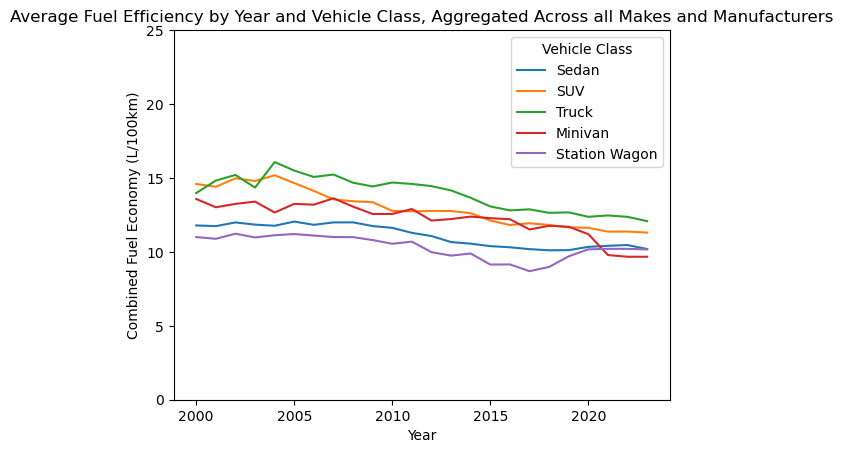

In [24]:
ax = grouped_vehicle_types.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Average Fuel Efficiency by Year and Vehicle Class, Aggregated Across all Makes and Manufacturers")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='upper right')

# Improvement by company

In [53]:
#Ford
ford_dataset = full_dataset.loc[full_dataset['make'] == 'Ford']
ford_dataset = ford_dataset[['model_year', 'vehicle_class','comb_lpkm']]
ford_dataset = ford_dataset.set_index("model_year").sort_index()
ford_dataset = ford_dataset.pivot_table(index="model_year", columns="vehicle_class", 
                                            values="comb_lpkm", aggfunc="mean")
ford_dataset

vehicle_class,Compact,Full-size,Mid-size,Minivan,Pickup truck: Small,Pickup truck: Standard,SUV,SUV: Small,SUV: Standard,Special purpose vehicle,Station wagon: Mid-size,Subcompact,Two-seater,Van: Cargo,Van: Passenger
model_year,,,,,,,,,,,,,,,
2000,9.985714,12.950000,11.550000,13.5,NaN,15.216667,15.741667,NaN,NaN,NaN,10.750000,12.580000,NaN,15.642857,17.066667
2001,9.866667,13.366667,12.000000,13.0,NaN,15.045455,14.400000,NaN,NaN,NaN,10.316667,12.480000,NaN,16.800000,16.500000
2002,9.150000,13.633333,11.500000,13.3,NaN,15.033333,14.630000,NaN,NaN,NaN,10.083333,11.850000,14.10,15.766667,16.966667
2003,9.150000,13.133333,12.675000,13.3,NaN,15.096154,14.320000,NaN,NaN,NaN,10.166667,12.742857,12.95,16.528571,17.700000
2004,9.660000,13.300000,11.800000,13.9,NaN,16.400000,15.150000,NaN,NaN,NaN,10.300000,12.511111,13.30,15.850000,16.800000
2005,11.300000,12.040000,12.600000,13.5,NaN,15.094444,13.038462,NaN,NaN,NaN,11.883333,NaN,13.00,15.100000,16.850000
2006,11.371429,13.100000,11.057143,13.8,NaN,14.378571,12.233333,NaN,NaN,NaN,9.250000,NaN,NaN,16.250000,16.850000
2007,11.700000,14.933333,11.228571,13.6,NaN,15.477273,12.023077,NaN,NaN,NaN,8.950000,NaN,NaN,13.600000,NaN
2008,11.757143,15.550000,11.133333,NaN,13.590000,16.542857,12.008333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
#grouping to clean up the plot, if we want to do that 
ford_grouped_dataset = pd.DataFrame()

ford_grouped_dataset["Sedan"] = ford_dataset[['Compact', 'Full-size', 'Mid-size', 'Subcompact']].mean(axis=1)
ford_grouped_dataset['SUV'] = ford_dataset[['SUV', 'SUV: Small','SUV: Standard']].mean(axis=1)
ford_grouped_dataset['Truck'] = ford_dataset[['Pickup truck: Small', 'Pickup truck: Standard']].mean(axis=1)

#don't have station wagon or minivan for most years so omitting
#ford_grouped_dataset['Minivan'] = ford_dataset['Minivan']
#ford_grouped_dataset['Station Wagon'] = ford_dataset['Station wagon: Mid-size']
ford_grouped_dataset

,Sedan,SUV,Truck
model_year,,,
2000,11.766429,15.741667,15.216667
2001,11.928333,14.400000,15.045455
2002,11.533333,14.630000,15.033333
2003,11.925298,14.320000,15.096154
2004,11.817778,15.150000,16.400000
2005,11.980000,13.038462,15.094444
2006,11.842857,12.233333,14.378571
2007,12.620635,12.023077,15.477273
2008,12.813492,12.008333,15.066429


In [65]:
#adding financials 
ford_grouped_dataset['R&D Expense'] = ford_grouped_dataset.index.map(ford_rnd)
ford_grouped_dataset

,Sedan,SUV,Truck,R&D Expense
model_year,,,,
2000,11.766429,15.741667,15.216667,6.8
2001,11.928333,14.400000,15.045455,7.3
2002,11.533333,14.630000,15.033333,7.7
2003,11.925298,14.320000,15.096154,7.5
2004,11.817778,15.150000,16.400000,7.4
2005,11.980000,13.038462,15.094444,8.0
2006,11.842857,12.233333,14.378571,7.2
2007,12.620635,12.023077,15.477273,7.5
2008,12.813492,12.008333,15.066429,7.3


Text(500, 50, 'The Great Financial Crisis hits \n the american auto industry')

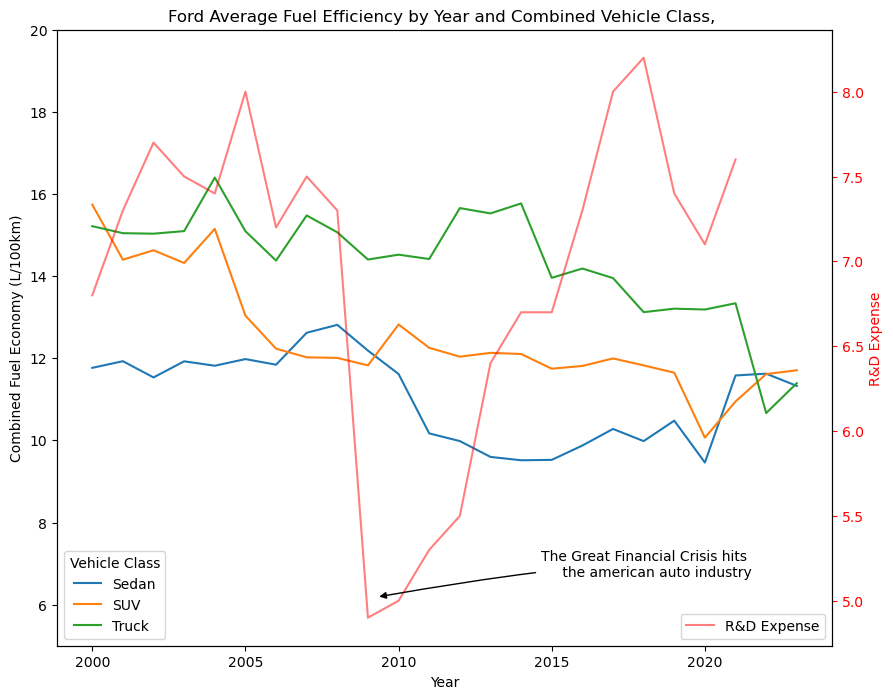

In [116]:
fig, ax = plt.subplots(figsize=(10,8))

ford_grouped_dataset[['Sedan', 'SUV', 'Truck']].plot.line(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(5, 20)
ax.set_title("Ford Average Fuel Efficiency by Year and Combined Vehicle Class, ")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='lower left')

ax_rnd = ax.twinx()
ax_rnd = ford_grouped_dataset['R&D Expense'].plot.line(color='red', alpha=0.5)
ax_rnd.set_ylabel('R&D Expense', color='r')
ax_rnd.tick_params(colors='r')
handles, labels = ax_rnd.get_legend_handles_labels()
ax_rnd.legend(handles, labels, loc='lower right') 
ax_rnd.annotate("The Great Financial Crisis hits \n the american auto industry", xy=(230, 35), 
                xycoords='axes points', xytext=(500, 50), annotation_clip=False, 
                horizontalalignment="right", arrowprops={
                    "arrowstyle": "-|>", "connectionstyle": "angle3,angleA=0,angleB=10", "color": "black"}, 
                fontsize=10)

# Retrieving RnD Expense

In [12]:
! pip install tabula-py

In [13]:
import tabula
from datetime import datetime

In [14]:
#scraping earnings data

#feed in URL and extract all tables from the pdf
url = "https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2007_consolidated.pdf"
all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
#print(all_dfs)

In [15]:
#find the table which contains the R&D expenses
for df in all_dfs:
    if ('R&D Expenses (billions of yen)' in df.values) or (
        'Research & Development (billions of yen)' in df.values):
        RnD_df = df
        RnD_df.reset_index(drop=True, inplace=True)
        break
        
RnD_df = RnD_df.set_index(RnD_df.columns[0])
#print(RnD_df)

In [16]:
#get full-year cols
#most pdfs have a col for 12 months/12 mos. ended so it's easy. For ones that dont, just going to look for 
#high nums which is a bit of a crappy workaround but good enough for now. Might want to find a better way later
#though since this won't be generalizable going way back 
check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
if len(check_format.columns) != 0:
    filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
else:
    try: 
        RnD_df = RnD_df.loc[:,RnD_df.loc["R&D Expense (billions of yen)"].notna()]
        filtered_RnD_df = RnD_df.iloc[:, [4, 9]]
    except KeyError: 
        try: 
            RnD_df = RnD_df.loc[:,RnD_df.loc["Research & Development (billions of yen)"].notna()]
            filtered_RnD_df = RnD_df.iloc[:, [4, 9]]
        except: print("No col found")

#remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
#.  the first rows. Removing both just in case. 
forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
if "Forecast" in filtered_RnD_df:
    filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)

#print(filtered_RnD_df)

/var/folders/cg/wggrqqlj4q52bf4vs_n4nmzw0000gn/T/ipykernel_4255/4147236158.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]


In [17]:
filtered_RnD_df = filtered_RnD_df.dropna(how='all')

fiscal_yr = []

filtered_RnD_df = filtered_RnD_df.dropna()

old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("FY")].values.tolist()
if len(old_dates) != 0:
    for date in old_dates[0]:
        year = int(date[2:6])
        fiscal_yr.append(year)
elif len(filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("'")].values.tolist()) != 0:
    date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
    for date_range in date_values[0].tolist():
        end_date_yr = date_range[8:10]
        year = int(end_date_yr) + 2000
        fiscal_yr.append(year)
else:
    try:
        date1 = int(all_dfs[0].iloc[:,0][6][2:])    #int(filtered_RnD_df.iloc[0,0][4:8])
    except ValueError:
        date1 = int(all_dfs[0].columns[2][2:])
    date2 = date1 + 1
    fiscal_yr.append(date1)
    fiscal_yr.append(date2)
        
filtered_RnD_df.columns = fiscal_yr

In [18]:
#extract to dict

if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
    toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
    toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']
    
toyota_rnd_dict = toyota_rnd_expenses.to_dict()
#print(toyota_rnd_dict)

## Copying the above into a single function:

In [19]:
! pip install tabula-py

In [20]:
import tabula
from datetime import datetime

In [21]:
#TEST
def retrieve_toyota_rnd_exp(url):
    """
    Parse the RnD Expense for each year from the given url (pdf file of Toyota earnings)
    Returns a dict with years and RnD expense (billions of yen)
    
    **Only seems to work on some pdfs right now (even though they look the same visually they load
    with slightly different columns it seems...). Can try to update later to be more general.
    
    """
    #scraping earnings data

    #feed in URL and extract all tables from the pdf
    all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
    
    #find the table which contains the R&D expenses
    for df in all_dfs:
        if ('R&D Expenses (billions of yen)' in df.values) or (
            'Research & Development (billions of yen)' in df.values):
            RnD_df = df
            RnD_df.reset_index(drop=True, inplace=True)
            break

    RnD_df = RnD_df.set_index(RnD_df.columns[0])
    
    #get full-year cols
    #most pdfs have a col for 12 months/12 mos. ended so it's easy. For ones that dont, just going to look for 
    #high nums which is a bit of a crappy workaround but good enough for now. Might want to find a better way later
    #though since this won't be generalizable going way back 
    check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
    if len(check_format.columns) != 0:
        filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
    else:
        RnD_df = RnD_df.loc[:,RnD_df.loc["R&D Expenses (billions of yen)"].notna()]
        filtered_RnD_df = RnD_df.iloc[:, [4, 9]]

    #remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
    #.  the first rows. Removing both just in case. 
    forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
    filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
    if "Forecast" in filtered_RnD_df:
        filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)
    
    #set col names to year 
    #find row with date - only row which contains an apostrophe is date row
    #had to drop NaNs first or else error
    filtered_RnD_df = filtered_RnD_df.dropna(how='all')

    fiscal_yr = []

    filtered_RnD_df = filtered_RnD_df.dropna()

    old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("FY")].values.tolist()
    if len(old_dates) != 0:
        for date in old_dates[0]:
            year = int(date[2:6])
            fiscal_yr.append(year)
    elif len(filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("'")].values.tolist()) != 0:
        date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
        for date_range in date_values[0].tolist():
            end_date_yr = date_range[8:10]
            year = int(end_date_yr) + 2000
            fiscal_yr.append(year)
    else:
        date1 = int(all_dfs[0].iloc[:,0][6][2:])    #int(filtered_RnD_df.iloc[0,0][4:8])
        date2 = date1 + 1
        fiscal_yr.append(date1)
        fiscal_yr.append(date2)

    filtered_RnD_df.columns = fiscal_yr
    
    #extract to dict
    if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
    elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']

    toyota_rnd_dict = toyota_rnd_expenses.to_dict()
    
    return toyota_rnd_dict

In [22]:
toyota_rnd_21_22 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2022_4q_summary_en.pdf")
toyota_rnd_20_21 =  retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2021_4q_summary_en.pdf")
toyota_rnd_19_20 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2020_4q_summary_en.pdf")
toyota_rnd_18_19 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2019_4q_summary_en.pdf")
toyota_rnd_17_18 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2018_summary.pdf")
#2017 doesnt work (https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_10_2017_consolidated.pdf)
toyota_rnd_15_16 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2016_consolidated.pdf")
toyota_rnd_14_15 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2015_consolidated.pdf")
toyota_rnd_13_14 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2014_consolidated.pdf")
toyota_rnd_12_13 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2013_consolidated.pdf")
toyota_rnd_11_12 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2012_consolidated.pdf")
toyota_rnd_10_11 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2011_consolidated.pdf")
toyota_rnd_09_10 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2010_consolidated.pdf")
toyota_rnd_08_09 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2009_consolidated.pdf")
toyota_rnd_07_08 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2008_consolidated.pdf")
#2007 doesn't work ()

Got stderr: Apr. 03, 2023 11:53:59 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:00 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:00 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:00 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:00 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14

Got stderr: Apr. 03, 2023 11:54:06 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:06 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:06 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14

/var/folders/cg/wggrqqlj4q52bf4vs_n4nmzw0000gn/T/ipykernel_4255/1000738884.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
Got

In [23]:
#test cell
#retrieve_toyota_rnd_exp("")

In [24]:
print(toyota_rnd_21_22)
print(toyota_rnd_20_21)
print(toyota_rnd_19_20)
print(toyota_rnd_18_19)
print(toyota_rnd_17_18)
print(toyota_rnd_15_16)
print(toyota_rnd_14_15)
print(toyota_rnd_13_14)
print(toyota_rnd_12_13)
print(toyota_rnd_11_12)
print(toyota_rnd_10_11)
print(toyota_rnd_09_10)
print(toyota_rnd_08_09) #dicrepancy here! there's two RnD expense values in the PDF for Japan/USA GAAP... 
print(toyota_rnd_07_08)

{2021: '1,090.4', 2022: '1,124.2'}
{2020: '1,110.3', 2021: '1,090.4'}
{2019: '1,048.8', 2020: '1,110.3'}
{2018: '1,064.2', 2019: '1,048.8'}
{2017: '1,037.5', 2018: '1,064.2'}
{2015: '1,004.5', 2016: '1,055.6'}
{2014: '910.5', 2015: '1,004.5'}
{2013: '807.4', 2014: '910.5'}
{2012: '779.8', 2013: '807.4'}
{2011: '730.3', 2012: '779.8'}
{2010: '725.3', 2011: '730.3'}
{2009: '904.0', 2010: '725.3'}
{2008: '818.5', 2009: '769.8'}
{2007: '890.7', 2008: '958.8'}


In [59]:
#ford reports this as "Engineering, research, and development" in billions USD
# from: https://shareholder.ford.com/Investors/financials/default.aspx#annual-reports
ford_rnd = {
    2021: 7.6,
    2020: 7.1,
    2019: 7.4,
    2018: 8.2,
    2017: 8.0,
    2016: 7.3,
    2015: 6.7, 
    2014: 6.7,
    2013: 6.4,
    2012: 5.5,
    2011: 5.3,
    2010: 5.0,
    2009: 4.9,
    2008: 7.3,
    2007: 7.5,
    2006: 7.2,
    2005: 8.0,
    2004: 7.4,
    2003: 7.5, 
    2002: 7.7,
    2001: 7.3,
    2000: 6.8
    
}

In [26]:
#Hyundai reports this as Total Research and development costs in millions of Korean Won
# from: https://www.hyundai.com/worldwide/en/company/ir/financial-information/financial-statements
#changed reporting before 2005 so not sure we'll find comparable data for those years
hyundai_rnd = {
    2022: 3_336_573,
    2021: 3_097_897,
    2020: 3_097_061,
    2019: 3_021_683,
    2018: 2_742_378,
    2017: 2_487_771,
    2016: 2_352_229,
    2015: 2_172_406,
    2014: 2_128_904,
    2013: 1_849_044,
    2012: 1_631_670,
    2011: 1_445_268,
    2010: 1_388_776,
    2009: 1_274_549,
    2008: 1_176_634,
    2007: 1_064_210,
    2006: 1_047_200,
    2005: 1_002_280,
}

In [27]:
#GM(chevy) reports as research and development expenses in billion USD
#from: https://investor.gm.com/sec-filings?field_nir_sec_form_group_target_id%5B%5D=471&field_nir_sec_date_filed_value=#views-exposed-form-widget-sec-filings-table
#no data before 2007
gm_rnd = {
    2022: 9.8,
    2021: 7.9, 
    2020: 6.2,
    2019: 6.8,
    2018: 7.8,
    2017: 7.3, 
    2016: 6.6,
    2015: 6.0,
    2014: 7.4,
    2013: 7.2,
    2012: 7.4,
    2011: 8.1,
    2010: 7.0,
    2009: 3.0,
    2008: 8.0,
    2007: 8.1,
    2006: 6.6,
    2005: 6.7,
    2004: 6.5,
    2003: 6.2,
    2002: 6.0,
    2001: 6.1,
    2000: 6.0
}

In [28]:
#Honda reports in millions (yen)
# from: https://global.honda/investors/library/financialresult.html
#nothing beyond 2012 on their website
honda_rnd = {
    2022: 787_056,
    2021: 738_894, 
    2020: 804_123,
    2019: 806_905,
    2018: 751_856,
    2017: 691_429,
    2016: 656_502,
    2015: 606_162,
    2014: 634_130,
    2013: 560_270,
    2012: 519_818,
    2011: 487_591,
    2010: 463_354,
    2009: 563_197,
    2008: 587_959,
    2007: 551_847, 
    2006: 510_385,
    2005: 467_754,
    2004: 448_967,
    2003: 436_863,
    2002: 395_176,
    2001: 352_829,
    2000: 334_036
}

In [29]:
# Stellantis owns fiat, crysler, jeep, dodge, Maserati, RAM, alfa romeo...
#Technically Stellantis was formed from a merger only in 2021. Before 2014-2021 was Fiat Chrysler, before that
# Chrysler Group LLC (2009-2014) and Chrysler LLC (2007-2009), DaimlerChrysler (1998-2007)... 
# history of M&A is too conveluded to provide useful data I think
# the reported numbers I can find are all over the place
stellantis_rnd = {
    2021: ,
    2020: ,
    2019: 3_612,
    2018: 3_051,
    2017: 3_230,
    2016: 3_274,
    2015: 2_864, 
    2014: 2_537,
    2013: 2_236,
    2012: 1_858,
    2011: 
}

In [30]:
#Nissan reports in billions of yen
#from: https://www.nissan-global.com/EN/IR/LIBRARY/
nissan_rnd = {
    2021: 484.1,
    2020: 503.5,
    2019: 544.8,
    2018: 523.1,
    2017: 495.8,
    2016: 490.4,
    2015: 531.9,
    2014: 506.1,
    2013: 500.6,
    2012: 469.9,
    2011: 428.0,
    2010: 399.3,
    2009: 385.5,
    2008: 455.5,
    2007: 457.5,
    2006: 464.8,
    2005: 447.6,
    2004: 398.1,
    2003: 354.3,
    2002: 300.3,
    2001: 262.1,
    2000: 231.7
}

In [31]:
# Kia reports in units of 100m KRW
# from: https://worldwide.kia.com/int/company/ir/archive/annual-report?p=1
kia_rnd = {
    2021: 18_719,
    2020: 16_730,
    2019: 17_682,
    2018: 16_649,
    2017: 16_419,
    2016: 16_464,
    2015: 15_235,
    2014: 12_699,
    2013: 12_415,
    2012: 10_270,
    2011: 9_922,
    2010: 8_673,
    2009: 7_146,
    2008: 7_481,
    2007: 5_971,
    2006: 5_681,
    2005: 5_657,
    2004: 5_386,
    2003: 4_275,
    2002: 3_925,
    2001: 1_143,
    2000: 734,
}

In [ ]:
#Volvo reports in units of millions of SEK (Swedish Krona)
# from: https://www.volvogroup.com/en/investors/reports-and-presentations/annual-reports.html

volvo_rnd = {
    2022: 22_526,
    2021: 18_027, 
    2020: 16_798,
    2019: 18_539,
    2018: 15_899,
    2017: 16_098,
    2016: 14_631,
    2015: 15_368,
    2014: 16_656
    2013: 15_124,
    2012: 14_794,
    2011: 13_276,
    2010: 13_000,
    2009: 13_200,
    2008: 14_300,
    2007: 11_100,
    2006: 8_400,
    2005: 7_600,
    2004: 7_600,
    2003: 6_800,
    2002: 5_900,
    2001: 5_400,
    2000: 4_876
}

In [ ]:
#Mercedes Benz Group reports in billions of euros
# from: https://group.mercedes-benz.com/investors/reports-news/annual-reports/download/

mercedes_rnd = {
    2022: 8.5,
    2021: 9.1,
    2020: 8.614,
    2019: 9.662,
    2018: 9.107,
    2017: 8.711 ,
    2016: 7.572,
    2015: 6.564,
    2014: 5.680,
    2013: 5.489,
    2012: 5.644,
    2011: 5.634,
    2010: 4.849,
    2009: 4.181,
    2008: 4.442,
    2007: 4.148,
    2006: 5.331,
    2005: 5.649,
    2004: 5.658,
    2003: 5.571,
    2002: 5.942,
    2001: 5.848,
    2000: 7.395
}

## Old code:

In [32]:
def retrieve_toyota_rnd_exp(url):
    """
    Parse the RnD Expense for each year from the given url (pdf file of Toyota earnings)
    Returns a dict with years and RnD expense (billions of yen)
    
    **Only seems to work on some pdfs right now (even though they look the same visually they load
    with slightly different columns it seems...). Can try to update later to be more general.
    
    """
    #scraping earnings data

    #feed in URL and extract all tables from the pdf
    all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
    
    #find the table which contains the R&D expenses
    for df in all_dfs:
        if ('R&D Expenses (billions of yen)' in df.values) or (
            'Research & Development (billions of yen)' in df.values):
            RnD_df = df
            RnD_df.reset_index(drop=True, inplace=True)
            break

    RnD_df = RnD_df.set_index(RnD_df.columns[0])
    
    #get full-year cols
    filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or (
        '12 mos. ended' in x.values))]

    #remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
    #.  the first rows. Removing both just in case. 
    forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
    filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
    if "Forecast" in filtered_RnD_df:
        filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)
    
    #set col names to year 
    #find row with date - only row which contains an apostrophe is date row
    #had to drop NaNs first or else error
    filtered_RnD_df = filtered_RnD_df.dropna(how='all')

    fiscal_yr = []

    old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("FY")].values.tolist()
    if len(old_dates) != 0:
        for date in old_dates[0]:
            year = int(date[2:6])
            fiscal_yr.append(year)
    else:
        date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
        for date_range in date_values[0].tolist():
            end_date_yr = date_range[8:10]
            year = int(end_date_yr) + 2000
            fiscal_yr.append(year)

    filtered_RnD_df.columns = fiscal_yr   
    
    #extract to dict
    if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
    elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']

    toyota_rnd_dict = toyota_rnd_expenses.to_dict()
    
    return toyota_rnd_dict

In [33]:
#filtered_RnD_df = float(str(RnD_df.loc[RnD_df.index[1]]).replace(",",""))
#for x in filtered_RnD_df.values:
#    print(float(str(x).replace(",", "")))

def remove_commas(s):
    if isinstance(s, str):
        return s.replace(',', '')
    else:
        return s

RnD_df = RnD_df.applymap(remove_commas)
RnD_df = RnD_df.fillna(-1)
#RnD_df = RnD_df.drop(columns=RnD_df.columns[0])
RnD_df.loc["R&D Expenses (billions of yen)"] = RnD_df.loc["R&D Expenses (billions of yen)"].astype(float)

RnD_df_filtered = RnD_df.loc["R&D Expenses (billions of yen)"] >= 500
RnD_df_filtered

KeyError: 'R&D Expenses (billions of yen)'